# Monte Carlo for Vector Functions of Integrals

Demo Accompanying [Aleksei Sorokin's PyData Chicago 2023 Talk](https://www.meetup.com/pydatachi/events/292071593/)

---

## Monte Carlo Problem

$$\text{True Mean} = \mu = \mathbb{E}[g(T)] = \mathbb{E}[f(X)] = \int_{[0,1]^d} f(x) \mathrm{d} x \approx \frac{1}{n} \sum_{i=0}^{n-1} f(X_i) = \hat{\mu} = \text{Sample Mean}$$

- $T$, original measure on $\mathcal{T}$
- $g: \mathcal{T} \to \mathbb{R}$, original integrand
- $X \sim \mathcal{U}[0,1]^d$, transformed measure
- $f: [0,1]^d \to \mathbb{R}$, transformed integrand

## Python Setup

In [1]:
import qmcpy as qp
import numpy as np
import scipy.stats
import pandas as pd
import time
from matplotlib import pyplot
colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

## Discrete Distribution

Generate sampling locations $X_0,\dots,X_{n-1} \sim \mathcal{U}[0,1]^d$

### Independent Identically Distributed (IID) Points for Crude Monte Carlo (CMC)

In [3]:
iid = qp.IIDStdUniform(dimension=3)
iid.gen_samples(n=4)

array([[0.2329066 , 0.43058283, 0.34912276],
       [0.76504267, 0.81516476, 0.559542  ],
       [0.90041766, 0.69023938, 0.92378415],
       [0.94532013, 0.34168431, 0.57663727]])

In [4]:
iid.gen_samples(4)

array([[0.29476491, 0.5837026 , 0.28321989],
       [0.59873347, 0.70614088, 0.74508089],
       [0.16673743, 0.00234912, 0.95505346],
       [0.66493855, 0.8174688 , 0.89916671]])

In [5]:
iid

IIDStdUniform (AbstractIIDDiscreteDistribution)
    d               3
    replications    1
    entropy         311952074974774304697579032664031966880

### Low Discrepancy (LD) Points for Quasi-Monte Carlo (QMC)

In [6]:
ld_lattice = qp.Lattice(3)
ld_lattice.gen_samples(4)

array([[0.36951616, 0.99328705, 0.37233532],
       [0.86951616, 0.49328705, 0.87233532],
       [0.61951616, 0.74328705, 0.12233532],
       [0.11951616, 0.24328705, 0.62233532]])

In [7]:
ld_lattice.gen_samples(4)

array([[0.36951616, 0.99328705, 0.37233532],
       [0.86951616, 0.49328705, 0.87233532],
       [0.61951616, 0.74328705, 0.12233532],
       [0.11951616, 0.24328705, 0.62233532]])

In [8]:
ld_lattice.gen_samples(n_min=2,n_max=4)

array([[0.61951616, 0.74328705, 0.12233532],
       [0.11951616, 0.24328705, 0.62233532]])

In [9]:
ld_lattice

Lattice (AbstractLDDiscreteDistribution)
    d               3
    replications    1
    randomize       SHIFT
    gen_vec_source  kuo.lattice-33002-1024-1048576.9125.txt
    order           NATURAL
    n_limit         2^(20)
    entropy         321246149664980673327814993762558511231

### Visuals

#### IID vs LD Points

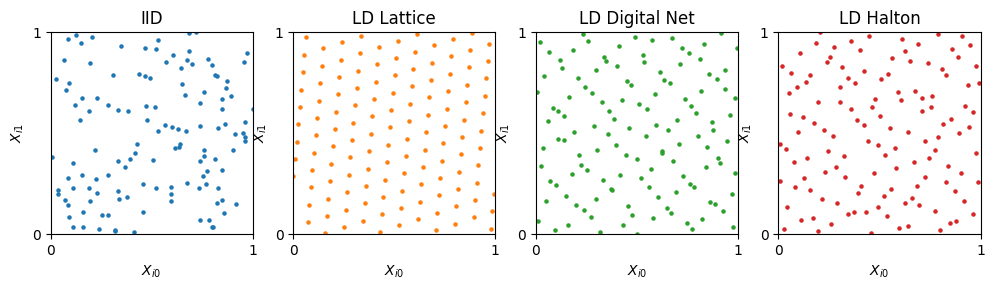

In [12]:
n = 2**7 # Lattice and Digital Net prefer powers of 2 sample sizes
discrete_distribs = {
    'IID': qp.IIDStdUniform(2),
    'LD Lattice': qp.Lattice(2),
    'LD Digital Net': qp.DigitalNetB2(2),
    'LD Halton': qp.Halton(2)}
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(n)
    ax[i].scatter(x[:,0],x[:,1],s=5,color=colors[i])
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

#### LD Space Filling Extensibility

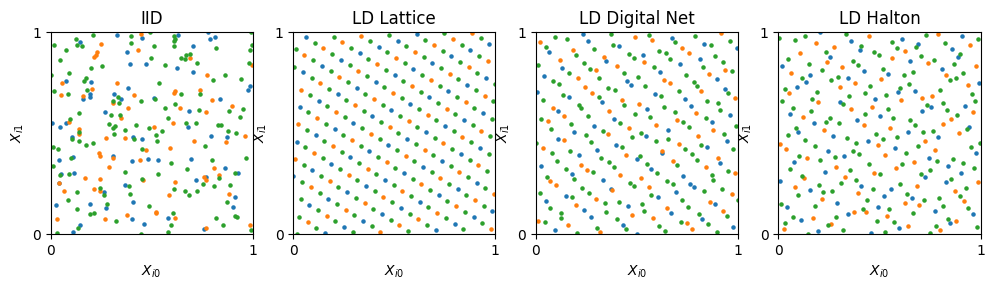

In [13]:
m_min,m_max = 6,8
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(2**m_max)
    n_min = 0
    for m in range(m_min,m_max+1):
        n_max = 2**m
        ax[i].scatter(x[n_min:n_max,0],x[n_min:n_max,1],s=5,color=colors[m-m_min],label='n_min = %d, n_max = %d'%(n_min,n_max))
        n_min = 2**m
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

#### High Dimensional Pairs Plotting

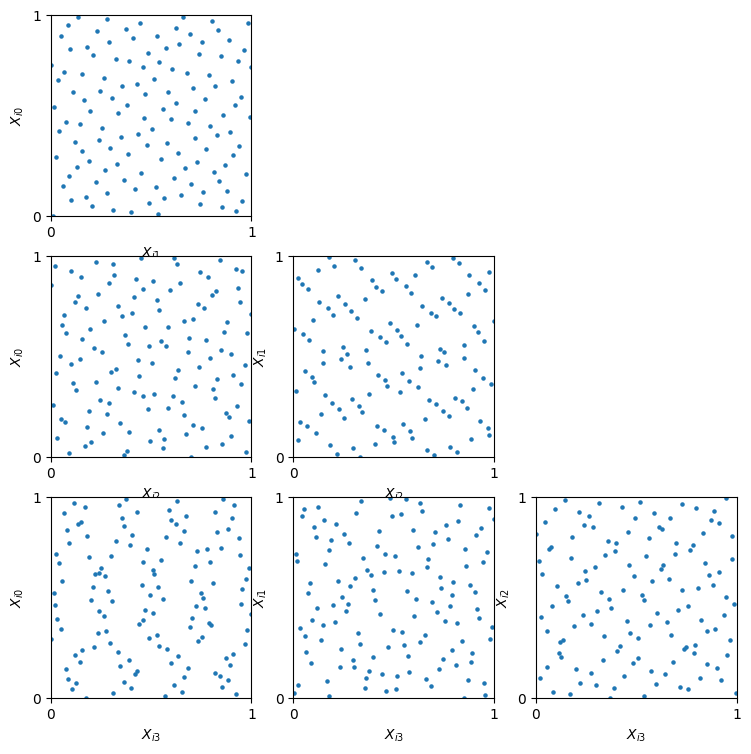

In [14]:
discrete_distrib = qp.DigitalNetB2(4)
x = discrete_distrib(2**7)
d = discrete_distrib.d
assert d>=2
fig,ax = pyplot.subplots(nrows=d,ncols=d,figsize=(3*d,3*d))
for i in range(d):
    fig.delaxes(ax[i,i])
    for j in range(i):
        ax[i,j].scatter(x[:,i],x[:,j],s=5)
        fig.delaxes(ax[j,i])
        ax[i,j].set_aspect(1)
        ax[i,j].set_xlabel(r'$X_{i%d}$'%i); ax[i,j].set_ylabel(r'$X_{i%d}$'%j)
        ax[i,j].set_xlim([0,1]); ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1]); ax[i,j].set_yticks([0,1])

## True Measure

Define $T$, facilitate transform from original integrand $g$ to transformed integrand $f$

In [15]:
discrete_distrib = qp.Halton(3)
true_measure = qp.Gaussian(discrete_distrib,mean=[1,2,3],covariance=[4,5,6])
true_measure.gen_samples(4)

array([[ 0.58596639,  3.09508721,  4.15289887],
       [ 2.86332254,  2.28505521,  2.01747267],
       [ 1.58007271,  0.57169596,  5.5769507 ],
       [-4.28771424,  5.32247145,  0.70992922]])

In [16]:
true_measure.gen_samples(n_min=2,n_max=4)

array([[ 1.58007271,  0.57169596,  5.5769507 ],
       [-4.28771424,  5.32247145,  0.70992922]])

In [17]:
true_measure

Gaussian (AbstractTrueMeasure)
    mean            [1 2 3]
    covariance      [4 5 6]
    decomp_type     PCA

### Visuals

#### Some True Measure Samplings

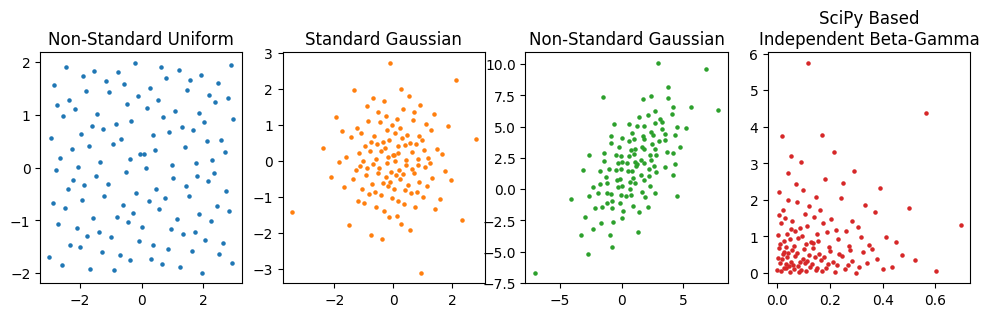

In [18]:
n = 2**7
discrete_distrib = qp.DigitalNetB2(2)
true_measures = {
    'Non-Standard Uniform': qp.Uniform(discrete_distrib,lower_bound=[-3,-2],upper_bound=[3,2]),
    'Standard Gaussian': qp.Gaussian(discrete_distrib),
    'Non-Standard Gaussian': qp.Gaussian(discrete_distrib,mean=[1,2],covariance=[[5,4],[4,9]]),
    'SciPy Based\nIndependent Beta-Gamma': qp.SciPyWrapper(discrete_distrib,[scipy.stats.beta(a=1,b=5),scipy.stats.gamma(a=1)])}
fig,ax = pyplot.subplots(nrows=1,ncols=len(true_measures),figsize=(3*len(true_measures),3))
ax = np.atleast_1d(ax)
for i,(name,true_measure) in enumerate(true_measures.items()):
    t = true_measure.gen_samples(n)
    ax[i].scatter(t[:,0],t[:,1],s=5,color=colors[i])
    ax[i].set_title(name)    

#### Brownian Motion

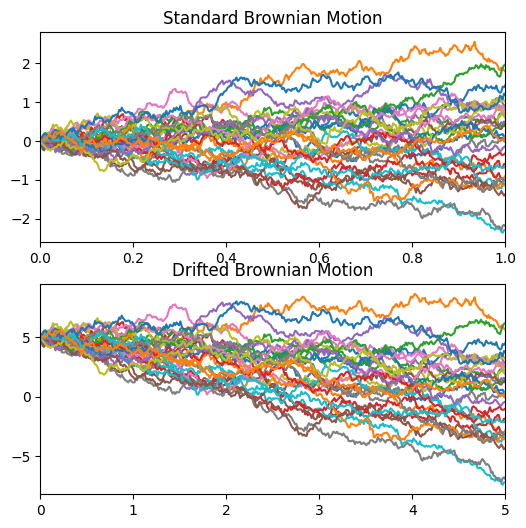

In [19]:
n = 32
discrete_distrib = qp.Lattice(365)
brownian_motions = {
    'Standard Brownian Motion': qp.BrownianMotion(discrete_distrib),
    'Drifted Brownian Motion': qp.BrownianMotion(discrete_distrib,t_final=5,initial_value=5,drift=-1,diffusion=2)}
fig,ax = pyplot.subplots(nrows=len(brownian_motions),ncols=1,figsize=(6,3*len(brownian_motions)))
ax = np.atleast_1d(ax)
for i,(name,brownian_motion) in enumerate(brownian_motions.items()):
    t = brownian_motion.gen_samples(n)
    t_w_init = np.hstack([brownian_motion.initial_value*np.ones((n,1)),t])
    tvec_w_0 = np.hstack([0,brownian_motion.time_vec])
    ax[i].plot(tvec_w_0,t_w_init.T)
    ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
    ax[i].set_title(name)

## Integrand

Define original integrand $g$, store transformed integrand $f$

### Wrap your Function into QMCPy

Our simple example
$$g(T) = T_0+T_1+\dots+T_{d-1}, \qquad T \sim \mathcal{N}(0,I_d)$$
$$f(X) = g(\Phi^{-1}(X)), \qquad \Phi \text{ standard normal CDF}$$
$$\mathbb{E}[f(X)] = \mathbb{E}[g(T)] = 0$$

In [20]:
def myfun(t): # define g, the ORIGINAL integrand 
    # t an (n,d) shaped np.ndarray of sample from the ORIGINAL (true) measure
    y = t.sum(1)
    return y # an (n,) shaped np.ndarray
true_measure = qp.Gaussian(qp.Halton(5)) # LD Halton discrete distrib for QMC problem
qp_myfun = qp.CustomFun(true_measure,myfun,parallel=False)

### Evalute the Automatically Transformed Integrand

In [21]:
x = qp_myfun.discrete_distrib.gen_samples(4) # samples from the TRANSFORMED measure
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
y

array([ 1.87780661,  0.29981093,  1.44265119, -0.84172604])

### Manual QMC Approximation

Note that when doing importance sampling the below doesn't work. In that case we need to take a specially weighted sum instead instead of the equally weighted sum as done below. 

In [22]:
x = qp_myfun.discrete_distrib.gen_samples(2**16) # samples from the TRANSFORMED measure
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
mu_hat = y.mean()
mu_hat

-1.5014582946549013e-05

### Predefined Integrands

Many more integrands detailed at https://qmcpy.readthedocs.io/en/master/algorithms.html#integrand-class

Integrands contain their true measure definition, so the user only needs to pass in a sampler. Samplers are often just discrete distributions. 

In [25]:
asian_option = qp.FinancialOption(
    sampler = qp.DigitalNetB2(52),
    option = "ASIAN",
    volatility = 1/2,
    start_price = 30,
    strike_price = 35,
    interest_rate = 0.001,
    t_final = 1,
    call_put = 'call',
    asian_mean = 'arithmetic')
x = asian_option.discrete_distrib.gen_samples(2**16)
y = asian_option.f(x)
mu_hat = y.mean()
mu_hat

1.7891760410330246

### Visual Transformation

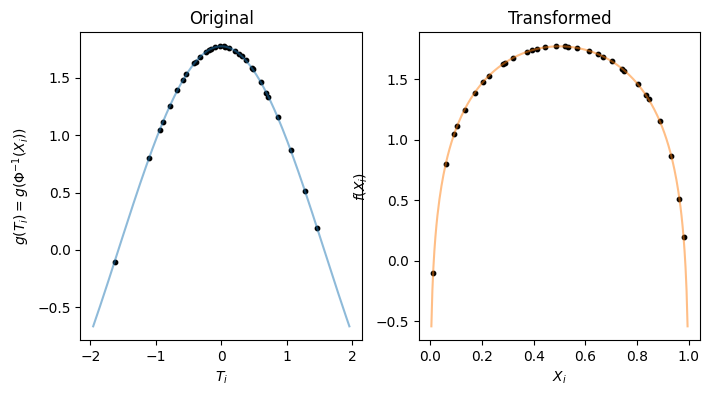

In [26]:
n = 32
keister = qp.Keister(qp.DigitalNetB2(1))
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,4))
x = keister.discrete_distrib.gen_samples(n)
t = keister.true_measure.gen_samples(n)
f_of_x = keister.f(x).squeeze()
g_of_t = keister.g(t).squeeze()
assert (f_of_x==g_of_t).all()
x_fine = np.linspace(0,1,257)[1:-1,None]
f_of_xfine = keister.f(x_fine).squeeze()
lb = 1.2*max(abs(t.min()),abs(t.max()))
t_fine = np.linspace(-lb,lb,257)[:,None]
g_of_tfine = keister.g(t_fine).squeeze()
ax[0].set_title(r'Original')
ax[0].set_xlabel(r'$T_i$'); ax[0].set_ylabel(r'$g(T_i) = g(\Phi^{-1}(X_i))$')
ax[0].plot(t_fine.squeeze(),g_of_tfine,color=colors[0],alpha=.5)
ax[0].scatter(t.squeeze(),f_of_x,s=10,color='k')
ax[1].set_title(r'Transformed')
ax[1].set_xlabel(r'$X_i$'); ax[1].set_ylabel(r'$f(X_i)$')
ax[1].scatter(x.squeeze(),f_of_x,s=10,color='k')
ax[1].plot(x_fine.squeeze(),f_of_xfine,color=colors[1],alpha=.5);

## Stopping Criterion

Adaptively increase $n$ until $\lvert \mu - \hat{\mu} \rvert < \varepsilon$ where $\varepsilon$ is a user defined tolerance. 

The stopping criterion should match the discrete distribution e.g. IID CMC stopping criterion for IID points, QMC Lattice stopping criterion for LD Lattice points, QMC digital net stopping criterion for LD digital net points, etc. 

### IID CMC Algorithm

In [27]:
problem_cmc = qp.FinancialOption(qp.IIDStdUniform(52),option="ASIAN")
cmc_stop_crit = qp.CubMCG(problem_cmc,abs_tol=0.025)
approx_cmc,data_cmc = cmc_stop_crit.integrate()
data_cmc

Data (Data)
    solution        1.786
    bound_low       1.761
    bound_high      1.811
    bound_diff      0.050
    n_total         422696
    time_integrate  4.918
CubMCG (AbstractStoppingCriterion)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_limit         2^(30)
    inflate         1.200
    alpha           0.010
    kurtmax         1.478
FinancialOption (AbstractIntegrand)
    option          ASIAN
    call_put        CALL
    volatility      2^(-1)
    start_price     30
    strike_price    35
    interest_rate   0
    t_final         1
    asian_mean      ARITHMETIC
BrownianMotion (AbstractTrueMeasure)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                     [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                     [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                     ...
  

### LD QMC Algorithm

In [28]:
problem_qmc = qp.FinancialOption(qp.DigitalNetB2(52),option="ASIAN")
qmc_stop_crit = qp.CubQMCNetG(problem_qmc,abs_tol=0.025)
approx_qmc,data_qmc = qmc_stop_crit.integrate()
data_qmc

Data (Data)
    solution        1.778
    comb_bound_low  1.754
    comb_bound_high 1.802
    comb_bound_diff 0.048
    comb_flags      1
    n_total         2^(10)
    n               2^(10)
    time_integrate  0.014
CubQMCNetG (AbstractStoppingCriterion)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_limit         2^(35)
FinancialOption (AbstractIntegrand)
    option          ASIAN
    call_put        CALL
    volatility      2^(-1)
    start_price     30
    strike_price    35
    interest_rate   0
    t_final         1
    asian_mean      ARITHMETIC
BrownianMotion (AbstractTrueMeasure)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                     [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                     [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                     ...
                     [0.019

In [29]:
print('QMC took %.2f%% the time and %.2f%% the samples compared to CMC'%(
      100*data_qmc.time_integrate/data_cmc.time_integrate,100*data_qmc.n_total/data_cmc.n_total))

QMC took 0.28% the time and 0.24% the samples compared to CMC


### Visual CMC vs LD

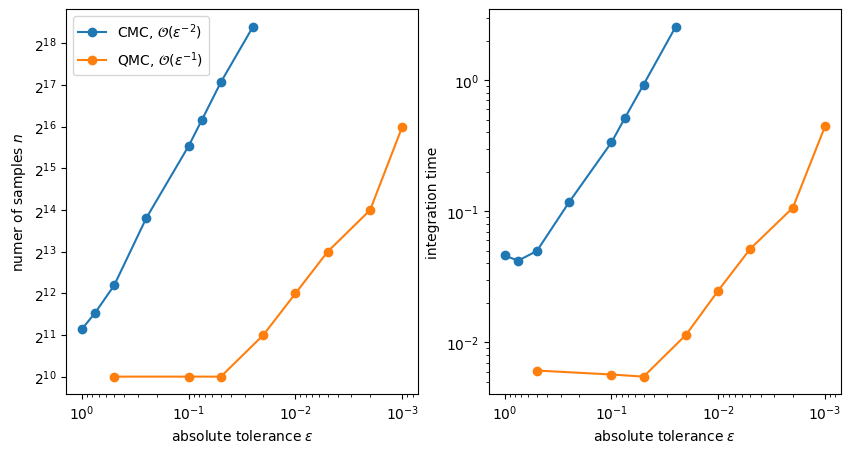

In [34]:
cmc_tols = [1,.75,.5,.25,.1,.075,.05,.025]
qmc_tols = [1,.5,.1,.05,.02,.01,.005,.002,.001]
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(10,5))
n_cmc,time_cmc = np.zeros_like(cmc_tols),np.zeros_like(cmc_tols)
for i,cmc_tol in enumerate(cmc_tols):
    cmc_stop_crit = qp.CubMCG(qp.FinancialOption(qp.IIDStdUniform(52),option="ASIAN"),abs_tol=cmc_tol)
    approx_cmc,data_cmc = cmc_stop_crit.integrate()
    n_cmc[i],time_cmc[i] = data_cmc.n_total,data_cmc.time_integrate
ax[0].plot(cmc_tols,n_cmc,'-o',color=colors[0],label=r'CMC, $\mathcal{O}(\varepsilon^{-2})$')
ax[1].plot(cmc_tols,time_cmc,'-o',color=colors[0])
n_qmc,time_qmc = np.zeros_like(qmc_tols),np.zeros_like(qmc_tols)
for i,qmc_tol in enumerate(qmc_tols):
    qmc_stop_crit = qp.CubQMCNetG(qp.FinancialOption(qp.DigitalNetB2(52),option="ASIAN"),abs_tol=qmc_tol)
    approx_qmc,data_qmc = qmc_stop_crit.integrate()
    n_qmc[i],time_qmc[i] = data_qmc.n_total,data_qmc.time_integrate
ax[0].plot(qmc_tols[1:],n_qmc[1:],'-o',color=colors[1],label=r'QMC, $\mathcal{O}(\varepsilon^{-1})$')
ax[1].plot(qmc_tols[1:],time_qmc[1:],'-o',color=colors[1])
ax[0].set_xscale('log',base=10); ax[0].set_yscale('log',base=2)
ax[1].set_xscale('log',base=10); ax[1].set_yscale('log',base=10)
ax[0].invert_xaxis(); ax[1].invert_xaxis()
ax[0].set_xlabel(r'absolute tolerance $\varepsilon$'); ax[1].set_xlabel(r'absolute tolerance $\varepsilon$')
ax[0].set_ylabel(r'numer of samples $n$'); ax[1].set_ylabel('integration time')
ax[0].legend(loc='upper left');

## Vectorized Stopping Criterion

Many more examples available at https://github.com/QMCSoftware/QMCSoftware/blob/master/demos/vectorized_qmc.ipynb

### Vector of Expectations

As a simple example, lets compute $\mathbb{E}[\cos(T_0)\cdots\cos(T_{d-1})]$ and $\mathbb{E}[\sin(T_0)\cdots\sin(T_{d-1})]$ where $T \sim \mathcal{U}[0,\pi]^d$

In [40]:
qmc_stop_crit = qp.CubQMCCLT(
    integrand = qp.CustomFun(
        true_measure = qp.Uniform(sampler=qp.Halton(3,replications=32),lower_bound=0,upper_bound=np.pi),
        g = lambda t: np.stack([np.cos(t).prod(-1),np.sin(t).prod(-1)],axis=0),
        dimension_indv = 2),
    abs_tol=.0001)
approx,data = qmc_stop_crit.integrate()
data

Data (Data)
    solution        [-1.394e-05  2.580e-01]
    comb_bound_low  [-9.721e-05  2.579e-01]
    comb_bound_high [6.932e-05 2.581e-01]
    comb_bound_diff [0. 0.]
    comb_flags      [ True  True]
    n_total         262144
    n               [262144 131072]
    n_rep           [8192 4096]
    time_integrate  1.565
CubQMCRepStudentT (AbstractStoppingCriterion)
    inflate         1
    alpha           0.010
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(8)
    n_limit         2^(30)
CustomFun (AbstractIntegrand)
Uniform (AbstractTrueMeasure)
    lower_bound     0
    upper_bound     3.142
Halton (AbstractLDDiscreteDistribution)
    d               3
    replications    2^(5)
    randomize       LMS_PERM
    t               63
    n_limit         2^(32)
    entropy         252515353135913233643914485259715985946

### Covariance

In a simple example, let $T \sim \mathcal{N}(1,I_d)$ and compute the covariance of $P = T_0\cdots T_{d-1}$ and $S = T_0+\dots+T_{d-1}$ so that 
$$\mathrm{Cov}[P,S] = \mathbb{E}[PS]-\mathbb{E}[P]\mathbb{E}[S] = \mu_0-\mu_1\mu_2$$
Theoretically we have $\mathrm{Cov}[P,S] = 2d-(1)(d) = d$

In [49]:
class CovIntegrand(qp.integrand.Integrand):
    def __init__(self, sampler):
        self.sampler = sampler
        self.true_measure = qp.Gaussian(sampler,mean=1)
        super(CovIntegrand,self).__init__(dimension_indv=3,dimension_comb=(),parallel=False)
    def g(self, t):
        P = t.prod(1) # P
        S = t.sum(1) # S
        PS = P*S #PS
        y = np.stack([PS,P,S],axis=0)
        return y
    def bound_fun(self, low, high):
        comb_low = low[0]-max(low[1]*low[2],low[1]*high[2],high[1]*low[2],high[1]*high[2])
        comb_high = high[0]-min(low[1]*low[2],low[1]*high[2],high[1]*low[2],high[1]*high[2])
        return comb_low,comb_high
    def dependency(self, comb_flag):
        return np.tile(comb_flag,3)
approx,data = qp.CubQMCLatticeG(CovIntegrand(qp.Lattice(10)),rel_tol=.025).integrate()
data

Data (Data)
    solution        10.065
    comb_bound_low  9.840
    comb_bound_high 10.301
    comb_bound_diff 0.461
    comb_flags      1
    n_total         2^(20)
    n               [1048576 1048576 1048576]
    time_integrate  3.213
CubQMCLatticeG (AbstractStoppingCriterion)
    abs_tol         0.010
    rel_tol         0.025
    n_init          2^(10)
    n_limit         2^(30)
CovIntegrand (AbstractIntegrand)
Gaussian (AbstractTrueMeasure)
    mean            1
    covariance      1
    decomp_type     PCA
Lattice (AbstractLDDiscreteDistribution)
    d               10
    replications    1
    randomize       SHIFT
    gen_vec_source  kuo.lattice-33002-1024-1048576.9125.txt
    order           NATURAL
    n_limit         2^(20)
    entropy         195896318778723510214474506600569967564

### Sensitiviy Indices

See Appendix A of [Art Owen's Monte Carlo Book](https://artowen.su.domains/mc/)

In the following example, we fit a neural network to Iris flower features and try to classify the Iris species. For each set of features, the classifier provides a probability of belonging to each species, a length 3 vector. We quantify the sensitiviy of this classificaiton probability to Iris features, assuming features are uniformly distributed throughout the feature domain.

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
data = load_iris()
og_feature_names = data["feature_names"]
feature_names = [fn.replace('sepal ','S')\
    .replace('length ','L')\
    .replace('petal ','P')\
    .replace('width ','W')\
    .replace('(cm)','') for fn in og_feature_names]
target_names = data["target_names"]
xt,xv,yt,yv = train_test_split(data["data"],data["target"],
    test_size = 1/3,
    random_state = 7)
pd.DataFrame(np.hstack([data['data'],data['target'][:,None]]),columns=og_feature_names+['species']).iloc[[0,1,90,91,140,141]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
90,5.5,2.6,4.4,1.2,1.0
91,6.1,3.0,4.6,1.4,1.0
140,6.7,3.1,5.6,2.4,2.0
141,6.9,3.1,5.1,2.3,2.0


In [3]:
mlpc = MLPClassifier(random_state=7,max_iter=1024).fit(xt,yt)
yhat = mlpc.predict(xv)
print("accuracy: %.1f%%"%(100*(yv==yhat).mean()))
# accuracy: 98.0%
sampler = qp.DigitalNetB2(4,seed=7)
true_measure =  qp.Uniform(sampler,
    lower_bound = xt.min(0),
    upper_bound = xt.max(0))
fun = qp.CustomFun(
    true_measure = true_measure,
    g = lambda x: mlpc.predict_proba(x).T,
    dimension_indv = 3)
si_fun = qp.SensitivityIndices(fun,indices="all")
qmc_algo = qp.CubQMCNetG(si_fun,abs_tol=.005)
nn_sis,nn_sis_data = qmc_algo.integrate()

accuracy: 98.0%


In [5]:
#print(nn_sis_data.flags_indv.shape)
#print(nn_sis_data.flags_comb.shape)
print('samples: 2^(%d)'%np.log2(nn_sis_data.n_total))
print('time: %.1e'%nn_sis_data.time_integrate)
print('indices:\n%s'%nn_sis_data.integrand.indices)

import pandas as pd

df_closed = pd.DataFrame(nn_sis[0],columns=target_names,index=[str(np.where(idx)[0]) for idx in nn_sis_data.integrand.indices])
print('\nClosed Indices')
print(df_closed)
df_total = pd.DataFrame(nn_sis[1],columns=target_names,index=[str(np.where(idx)[0]) for idx in nn_sis_data.integrand.indices])
print('\nTotal Indices')
df_closed_singletons = df_closed.loc[['[%d]'%i for i in range(4)]].T
df_closed_singletons['sum singletons'] = df_closed_singletons[['[%d]'%i for i in range(4)]].sum(1)
df_closed_singletons.columns = data['feature_names']+['sum']
df_closed_singletons = df_closed_singletons*100
df_closed_singletons

samples: 2^(15)
time: 1.8e+00
indices:
[[ True False False False]
 [False  True False False]
 [False False  True False]
 [False False False  True]
 [ True  True False False]
 [ True False  True False]
 [ True False False  True]
 [False  True  True False]
 [False  True False  True]
 [False False  True  True]
 [ True  True  True False]
 [ True  True False  True]
 [ True False  True  True]
 [False  True  True  True]]

Closed Indices
           setosa  versicolor  virginica
[0]      0.000000    0.067568   0.099035
[1]      0.051979    0.002589   0.000000
[2]      0.712711    0.326664   0.498664
[3]      0.051251    0.018706   0.120796
[0 1]    0.052284    0.080725   0.112412
[0 2]    0.714204    0.462147   0.641450
[0 3]    0.050927    0.086925   0.207602
[1 2]    0.840864    0.433329   0.514042
[1 3]    0.102538    0.004948   0.126151
[2 3]    0.822405    0.583743   0.705192
[0 1 2]  0.843055    0.571913   0.661004
[0 1 3]  0.103351    0.103411   0.217246
[0 2 3]  0.824347    0.816010   0

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sum
setosa,0.000000,5.197885,71.271100,5.125145,81.594130
versicolor,6.756844,0.258851,32.666361,1.870561,41.552616
virginica,9.903452,0.000000,49.866351,12.079616,71.849419


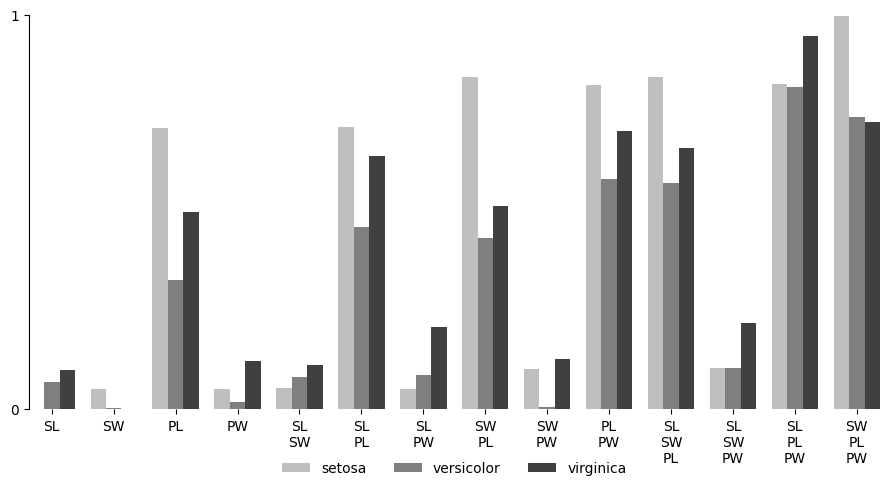

In [7]:
nindices = len(nn_sis_data.integrand.indices)
fig,ax = pyplot.subplots(figsize=(9,5))
ticks = np.arange(nindices)
width = .25
for i,(alpha,species) in enumerate(zip([.25,.5,.75],data['target_names'])):
    cvals = df_closed[species].to_numpy()
    tvals = df_total[species].to_numpy()
    ticks_i = ticks+i*width
    ax.bar(ticks_i,cvals,width=width,align='edge',color='k',alpha=alpha,label=species)
    #ax.bar(ticks_i,np.flip(tvals),width=width,align='edge',bottom=1-np.flip(tvals),color=color,alpha=.1)
ax.set_xlim([0,13+3*width])
ax.set_xticks(ticks+1.5*width)

# closed_labels = [r'$\underline{s}_{\{%s\}}$'%(','.join([r'\text{%s}'%feature_names[i] for i in idx])) for idx in nn_sis_data.integrand.indices]
closed_labels = ['\n'.join([feature_names[i] for i in np.where(idx)[0]]) for idx in nn_sis_data.integrand.indices]
ax.set_xticklabels(closed_labels,rotation=0)
ax.set_ylim([0,1]); ax.set_yticks([0,1])
ax.grid(False)
for spine in ['top','right','bottom']: ax.spines[spine].set_visible(False)
ax.legend(frameon=False,loc='lower center',bbox_to_anchor=(.5,-.2),ncol=3);
fig.tight_layout()